# Relaxed In Contact Pair Mode

In [1]:
from large_gcs.contact.contact_pair_mode import (
    generate_contact_pair_modes,
    generate_no_contact_pair_modes,
    RelaxedInContactPairMode,
)
from large_gcs.contact.rigid_body import RigidBody, MobilityType
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np
from IPython.display import HTML

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt

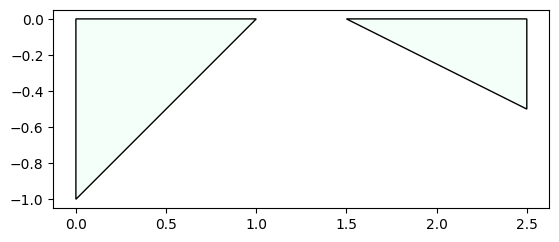

In [14]:
obj_vertices = np.array([[0, 0], [1, 0], [1, -0.5]]) + np.array([1.5, 0])
# obj_vertices = np.array([[0, 0], [1, 0.2], [0.7, -0.5]]) + np.array([1.5,0])
# obj_vertices = np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([1.5,0])
rob = RigidBody(
    name="robot",
    geometry=Polyhedron.from_vertices([[0, 0], [1, 0], [0, -1]]),
    mobility_type=MobilityType.ACTUATED,
)
obj = RigidBody(
    name="object",
    geometry=Polyhedron.from_vertices(obj_vertices),
    mobility_type=MobilityType.UNACTUATED,
)
rob.geometry.plot()
obj.geometry.plot()

In [3]:
ric = RelaxedInContactPairMode(obj, rob)
ric.base_constraint_formulas

[<Formula "((-0.66661306918630192 + robot_pos(0, 0) - object_pos(0, 0)) <= 0)">,
 <Formula "((( - 0.89442719099991586 * (0.46669564310376066 + robot_pos(1, 0) - object_pos(1, 0)) - 0.44721359549995793 * (0.73337198284751837 + robot_pos(0, 0) - object_pos(0, 0))) / 0.99999999999999989) <= 0)">,
 <Formula "((-0.83331183087934768 + robot_pos(1, 0) - object_pos(1, 0)) <= 0)">]

In [4]:
nc_modes = generate_no_contact_pair_modes(obj, rob)
for mode in nc_modes:
    print(mode.base_constraint_formulas)

[<Formula "((-0.66661306918630192 + robot_pos(0, 0) - object_pos(0, 0)) >= 0)">]
[<Formula "((( - 0.89442719099991586 * (0.46669564310376066 + robot_pos(1, 0) - object_pos(1, 0)) - 0.44721359549995793 * (0.73337198284751837 + robot_pos(0, 0) - object_pos(0, 0))) / 0.99999999999999989) >= 0)">]
[<Formula "((-0.83331183087934768 + robot_pos(1, 0) - object_pos(1, 0)) >= 0)">]


In [5]:
ric.constraint_formulas

[<Formula "((-0.66661306918630192 + robot_pos(0, 0) - object_pos(0, 0)) <= 0)">,
 <Formula "((-0.66661306918630192 + robot_pos(0, 1) - object_pos(0, 1)) <= 0)">,
 <Formula "((( - 0.89442719099991586 * (0.46669564310376066 + robot_pos(1, 0) - object_pos(1, 0)) - 0.44721359549995793 * (0.73337198284751837 + robot_pos(0, 0) - object_pos(0, 0))) / 0.99999999999999989) <= 0)">,
 <Formula "((( - 0.89442719099991586 * (0.46669564310376066 + robot_pos(1, 1) - object_pos(1, 1)) - 0.44721359549995793 * (0.73337198284751837 + robot_pos(0, 1) - object_pos(0, 1))) / 0.99999999999999989) <= 0)">,
 <Formula "((-0.83331183087934768 + robot_pos(1, 0) - object_pos(1, 0)) <= 0)">,
 <Formula "((-0.83331183087934768 + robot_pos(1, 1) - object_pos(1, 1)) <= 0)">,
 <Formula "(robot_force_act(0) == robot_force_res(0))">,
 <Formula "(robot_force_act(1) == robot_force_res(1))">,
 <Formula "(object_force_res(0) == robot_force_res(0))">,
 <Formula "(object_force_res(1) == robot_force_res(1))">]

# Incremental Relaxed Contact Graph

In [6]:
from collections import namedtuple
from dataclasses import dataclass
from enum import Enum
import heapq as heap
from copy import copy
from typing import Optional, List
import numpy as np
from IPython.display import HTML

from large_gcs.graph.incremental_relaxed_contact_graph import (
    IncrementalRelaxedContactGraph,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph.graph import ShortestPathSolution, Graph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)
from large_gcs.graph.factored_collision_free_graph import FactoredCollisionFreeGraph

In [7]:
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger("drake").setLevel(logging.ERROR)

In [8]:
graph_name = "cg_radialsort_a1"
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name(graph_name)
# cg_inc = IncrementalContactGraph.load_from_file(graph_file, should_add_gcs=True)
cg_inc_relaxed = IncrementalRelaxedContactGraph.load_from_file(
    graph_file, should_add_gcs=True, should_incl_simul_mode_switches=False
)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28532.68it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11351.30it/s]
INFO:large_gcs.graph.incremental_relaxed_contact_graph:Generating contact pair modes for 12 body pairs...
100%|██████████| 3/3 [00:00<00:00, 112.47it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (264)
100%|██████████| 264/264 [00:00<00:00, 6356.36it/s]


In [9]:
# setid = tuple(['NC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'RNC|obj0-obj1', 'RNC|obj0-obj2', 'RIC|obj1-obj2', 'RIC|obj0-rob0', 'RNC|obj1-rob0', 'RNC|obj2-rob0'])
# cg_inc_relaxed._get_no_rob_contact_objs(setid)

In [10]:
# setid = tuple(['NC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'RNC|obj0-obj1', 'RNC|obj0-obj2', 'RNC|obj1-obj2', 'RNC|obj0-rob0', 'RNC|obj1-rob0', 'RNC|obj2-rob0'])
# cg_inc_relaxed._get_no_rob_contact_objs(setid)

In [11]:
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)

# cost_estimator = ShortcutEdgeCE(
#     cg_inc_relaxed, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
# )
cost_estimator = FactoredCollisionFreeCE(
    cg_inc_relaxed, use_combined_gcs=False, obj_multiplier=100
)
gcs_astar = GcsAstarConvexRestriction(
    cg_inc_relaxed,
    reexplore_level=ReexploreLevel.NONE,
    cost_estimator=cost_estimator,
)
sol = gcs_astar.run()

INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 16/16 [00:00<00:00, 7753.77it/s]
INFO:large_gcs.graph.graph:Adding 16 vertices to graph...
100%|██████████| 16/16 [00:00<00:00, 14119.26it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 120/120 [00:00<00:00, 6945.94it/s]
INFO:large_gcs.graph.contact_graph:190 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 190/190 [00:00<00:00, 15162.06it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 190/190 [00:00<00:00, 9151.87it/s]
INFO:large_gcs.graph.graph:Adding 190 edges to graph...
100%|██████████| 190/190 [00:00<00:00, 8593.22it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Created factored collision free graph for obj0: GraphParams(dim_bounds=(2, 4), n_vertices=16, n_edges=190, source=[array([-1.300, -2.300])], target='regions', workspace=arra

In [12]:
# v = cg_inc_relaxed.vertices["('NC|obs0_f1-obj0_f3', 'NC|obs0_f1-obj1_f3', 'NC|obs0_f1-obj2_f3', 'NC|obs0_f3-rob0_v1', 'RNC|obj0-obj1', 'RNC|obj0-obj2', 'RNC|obj1-obj2', 'RNC|obj0-rob0', 'RNC|obj1-rob0', 'RNC|obj2-rob0')"]
# v.convex_set.vars.force_res_from_vars(sol.ambient_path[2])
# v.convex_set.vars.pos_from_all(sol.ambient_path[2])
# sol.ambient_path[1]

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmuiowiuz/temp.m4v


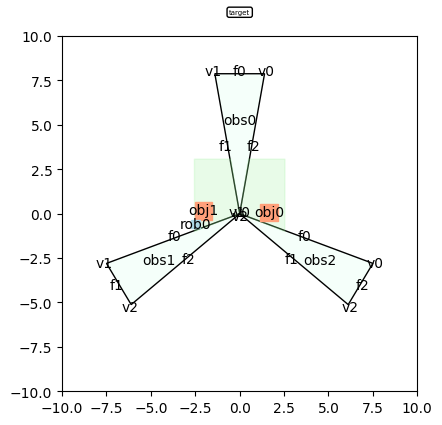

In [13]:
anim = cg_inc_relaxed.animate_solution()
HTML(anim.to_html5_video())